# Introduction
This is the final project for Deep Learning.  For this assignment I built off the project I turned in last time that used the dataset found https://www.kaggle.com/datasets/ayuraj/asl-dataset.  The goal of this task is to use convolution to be able predict what letter or number is being shown for an ASL picture.  For this dataset we have 36 classes.

We added Regularization and Self Supervised Learning to this colab.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

##Upload Dataset
The dataset can be downloaded as a zip folder.  Inside the folder each class is organized into its own folder

In [ ]:
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
#unzip zip file
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
  zip_ref.extractall()

## Represent Pictures

Now that we have uploaded our dataset we want to be able to train models with it.  To do this we want to represent each picture as a numpy array.  Each picture is currently 400x400 pixels which would take way too much time and resources to train so we will resize to 32x32.  The resolution will be a little blurry but you can still make out the pictures.

In [ ]:
# create numpy arrays and save them
X = []
Y  = []
labels = dict()
idx = 0
for filename in os.listdir('asl_dataset'):
  if filename == 'asl_dataset':
    # second folder for some reason
    continue
  if filename not in labels:
    labels[filename] = idx
    idx += 1
  for image in os.listdir('asl_dataset/' + filename):
    img = Image.open('asl_dataset/' + filename + '/' + image)
    X.append(np.asarray(img.resize(size = (32,32)))) # values between 0 and 1
    Y.append(labels[filename])


We want to split data to be able to test our neural networks.

In [ ]:
reverse_labels = dict({i: name for name, i in labels.items()})
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y))

Since we are using SGD for our optizimers it is super important that everything is random

In [ ]:
np.random.seed(0)

indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [ ]:
print(labels)

{'k': 0, 'a': 1, 'f': 2, 'l': 3, 'o': 4, 'e': 5, '1': 6, '4': 7, 's': 8, 'i': 9, 'z': 10, '6': 11, 'q': 12, 'u': 13, '5': 14, '9': 15, 'c': 16, 'j': 17, 'd': 18, 'b': 19, 'y': 20, '8': 21, 'p': 22, 'g': 23, '0': 24, 'v': 25, 'h': 26, 'x': 27, 't': 28, 'n': 29, '7': 30, 'w': 31, 'm': 32, 'r': 33, '2': 34, '3': 35}


In [ ]:
# if we need to display a single image
def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

# Baseline

When we use deep learning we want to make sure our models serve a purpose.  In order to do this we set a baseline which has no relation to our models.  Our models must beat this baseline to be considered an improvement

## Educated Guess
Lets look and see what the most popular class is in the dataset.  And lets make that our prediction for every example.  Our models have to beat this accuracy score

In [ ]:
most_common = np.bincount(Y_train).argmax()
pred_baseline = np.empty(Y_test.shape[0])
pred_baseline.fill(most_common)
print("Baseline accuracy", accuracy_score(Y_test, pred_baseline))

Baseline accuracy 0.02066772655007949


# Data Analysis

## Display Dataset

Now that we have organized our dataset we can check it visually to ensure the labels matchup and we can still read our data.  Below is the first 10 images in the train dataset.

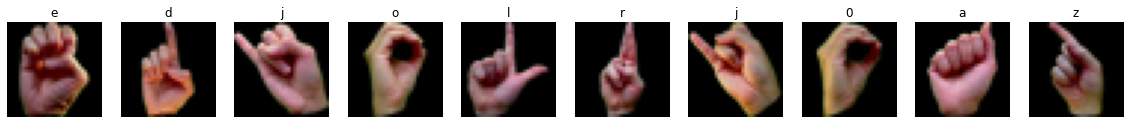

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,10))
for i in range(10):
  image = X_train[i]
  label = reverse_labels[Y_train[i]]
  axs[i].imshow(image)
  axs[i].set_title(label)
  axs[i].axis('off')
plt.show()

Here are the first 10 images in the test dataset.

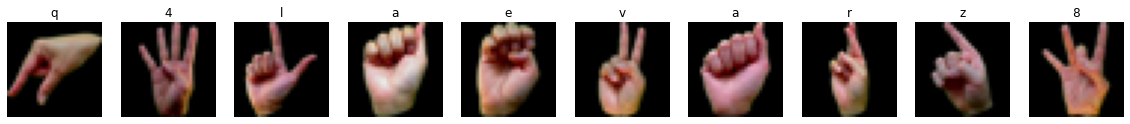

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,10))
for i in range(10):
  image = X_test[i]
  label = reverse_labels[Y_test[i]]
  axs[i].imshow(image)
  axs[i].set_title(label)
  axs[i].axis('off')
plt.show()

If we notice the pictures have some differences between them.  Some pictures are brighter while others are taken at a slightly different angle.  Overall, the dataset seems very use to use with a regression neural network.  Here are the first 10 'a's in the dataset to show the differences.

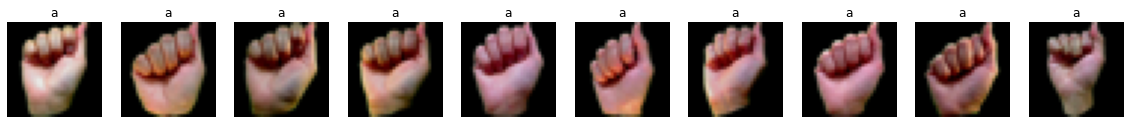

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,10))
X_a = X_train[Y_train == labels['a']][:10]
for i in range(10):
  image = X_a[i]
  label = 'a'
  axs[i].imshow(image)
  axs[i].set_title(label)
  axs[i].axis('off')
plt.show()

## Double check shapes

These are color images that are 32x32 pixels.  Since it is colored, the shape of the numpy array that corresponds to the image should be 32x32x3.  The number of X_train example should be the same as Y_train classifications. And the same with the testing data set.[link text](https://)

In [ ]:
print('X_train.shape', X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_test.shape', X_test.shape)
print('Y_test.shape', Y_test.shape)

X_train.shape (1886, 32, 32, 3)
Y_train.shape (1886,)
X_test.shape (629, 32, 32, 3)
Y_test.shape (629,)


# Regularization

In previous test with these models, the performed overall very well.  However, there seemed to be some sort of overfitting with each of the models.  To fix this we added some dropout to 1 layer of the neural networks.

This was extremely necessary as the data set could be considered to be on the smaller side.  So it really improved the overall performance and prevented the problem of overfitting

# Experimentation 

## Build Neural Networks

Now it is time to build our Neural Networks.  To do this it is best to use a convolutional neural network since there is multiple classes each image can be.  Since we are trying to do convolution we will use stochastic gradient descent.  When doing this it is important to make sure that everything is random

### 4 Convolutions

For our first model we will do a logistric regression model with 4 convolutions

In [ ]:
def build_model_4(input_shape, num_classes, learning_rate=0.01):

  # make sure everything is random
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)


  model = keras.Sequential()

  # 32x32x3
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                  input_shape=input_shape))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.1))

  # 32x32x64
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.1))

  # 30x30x64
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # 15X15x128
  model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
  model.add(keras.layers.Activation('relu'))

  # 15X15x128
  model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))

  # 13X13x128
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # 6X6x128
  model.add(keras.layers.Flatten())

  # 4608
  model.add(keras.layers.Dense(units=512))
  # 512
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Dense(units=num_classes))
  model.add(keras.layers.Activation('softmax'))
  

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=0.5)
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


  return model


### 2 Convolutions

Now we will do a logistic regression model with only 2 convolutions.  One of 64 filters and one of 128 filters

In [ ]:
def build_model_2(input_shape, num_classes, learning_rate=0.01):

  # make sure everything is random
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  num_classes = 36

  model = keras.Sequential()

  # 32x32x3
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                  input_shape=input_shape))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.1))


  # 32x32x64
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))


  # 15X15x64
  model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
  model.add(keras.layers.Activation('relu'))

  # 13X13x128
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # 6X6x128
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(units=512))
  # 512
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Dense(units=num_classes))
  model.add(keras.layers.Activation('softmax'))
  

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=0.5)
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


  return model


### 1 Convolution
For our last model we will again do logistic regression with only one convolution with 64 filters.

In [ ]:
def build_model_1(input_shape, num_classes, learning_rate=0.01):

  # make sure everything is random
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)


  model = keras.Sequential()

  # 32x32x3
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                  input_shape=input_shape))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.1))


  # 32x32x64
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))


  # 13X13x64
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # 6X6x64
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(units=512))
  # 512
  model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.Dense(units=num_classes))
  model.add(keras.layers.Activation('softmax'))
  

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=0.5)
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


  return model

### Fit the models

Now we will fit the models and predict from each of them. We will reserve 10% of the train data for validation

## 4 Convolutions Training Performance
In the end the training accuracy was nearly 99% and the validation accuracy was nearly 97%.  As the model continued training, it seems the validation loss continued to imporve.

In [ ]:
model_4 = build_model_4(input_shape=X_train[0].shape, num_classes=36, learning_rate=0.01)
# Fit the model.
history = model_4.fit(
  x = X_train,   
  y = Y_train,   
  epochs=15,             
  batch_size=64,        
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
display(history)



Epoch 1/15
27/27 [==============================] - 16s 547ms/step - loss: 8.8420 - accuracy: 0.1019 - val_loss: 2.7772 - val_accuracy: 0.2116
Epoch 2/15
27/27 [==============================] - 15s 548ms/step - loss: 2.1150 - accuracy: 0.4402 - val_loss: 1.1642 - val_accuracy: 0.6667
Epoch 3/15
27/27 [==============================] - 15s 546ms/step - loss: 0.8217 - accuracy: 0.7596 - val_loss: 0.6837 - val_accuracy: 0.7778
Epoch 4/15
27/27 [==============================] - 15s 542ms/step - loss: 0.4949 - accuracy: 0.8486 - val_loss: 0.6419 - val_accuracy: 0.8201
Epoch 5/15
27/27 [==============================] - 15s 540ms/step - loss: 0.3205 - accuracy: 0.8981 - val_loss: 0.3003 - val_accuracy: 0.8995
Epoch 6/15
27/27 [==============================] - 15s 542ms/step - loss: 0.2058 - accuracy: 0.9334 - val_loss: 0.6109 - val_accuracy: 0.8519
Epoch 7/15
27/27 [==============================] - 15s 543ms/step - loss: 0.1838 - accuracy: 0.9417 - val_loss: 0.3746 - val_accuracy: 0.8836

,loss,accuracy,val_loss,val_accuracy
0,8.841954,0.101945,2.777155,0.211640
1,2.114987,0.440189,1.164216,0.666667
2,0.821662,0.759576,0.683738,0.777778
3,0.494856,0.848556,0.641949,0.820106
4,0.320503,0.898055,0.300256,0.899471
5,0.205775,0.933412,0.610885,0.851852
6,0.183812,0.941662,0.374608,0.883598
7,0.123339,0.962286,0.258212,0.910053
8,0.107400,0.965822,0.206863,0.952381
9,0.064805,0.980554,0.258535,0.920635


In [ ]:
pred_4 = model_4.predict(X_test)
pred_4 = np.argmax(pred_4, axis=1)

20/20 [==============================] - 1s 69ms/step


## 2 Convolutions Training Performance

To my suprise the training with 2 convolutions seemed to perform ever so slightly better in training accuracy than the 4 convolutions.  With nearly 100% training accuracy.  However, the validation accuracy was slightly lower but almost the same compared to the 4 convolutions.

In [ ]:
model_2 = build_model_2(input_shape=X_train[0].shape, num_classes=36, learning_rate=0.01)
# Fit the model.
history = model_2.fit(
  x = X_train,   
  y = Y_train,   
  epochs=15,             
  batch_size=64,        
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
display(history)

Epoch 1/15
27/27 [==============================] - 5s 186ms/step - loss: 24.1906 - accuracy: 0.3276 - val_loss: 1.1111 - val_accuracy: 0.6667
Epoch 2/15
27/27 [==============================] - 5s 187ms/step - loss: 0.8308 - accuracy: 0.7507 - val_loss: 0.9221 - val_accuracy: 0.7513
Epoch 3/15
27/27 [==============================] - 5s 183ms/step - loss: 0.5075 - accuracy: 0.8415 - val_loss: 0.5211 - val_accuracy: 0.8624
Epoch 4/15
27/27 [==============================] - 5s 183ms/step - loss: 0.2752 - accuracy: 0.9034 - val_loss: 0.3824 - val_accuracy: 0.8466
Epoch 5/15
27/27 [==============================] - 5s 182ms/step - loss: 0.2120 - accuracy: 0.9287 - val_loss: 0.2816 - val_accuracy: 0.8783
Epoch 6/15
27/27 [==============================] - 5s 196ms/step - loss: 0.1464 - accuracy: 0.9529 - val_loss: 0.5272 - val_accuracy: 0.8889
Epoch 7/15
27/27 [==============================] - 5s 183ms/step - loss: 0.1334 - accuracy: 0.9564 - val_loss: 0.3713 - val_accuracy: 0.8995
Epoch

,loss,accuracy,val_loss,val_accuracy
0,24.190607,0.327637,1.111110,0.666667
1,0.830804,0.750737,0.922066,0.751323
2,0.507506,0.841485,0.521053,0.862434
3,0.275172,0.903359,0.382419,0.846561
4,0.211961,0.928698,0.281612,0.878307
5,0.146366,0.952858,0.527246,0.888889
6,0.133415,0.956394,0.371258,0.899471
7,0.087549,0.973483,0.307454,0.915344
8,0.057982,0.984679,0.240039,0.931217
9,0.046387,0.989393,0.217173,0.952381


In [ ]:
pred_2 = model_2.predict(X_test)
pred_2 = np.argmax(pred_2, axis=1)

20/20 [==============================] - 1s 22ms/step


## 1 Convolution Training Performance
This model was suprising.  It seemed to reach almost 100% accuracy in training but its validation accuracy was lower than the rest.

In [ ]:
model_1 = build_model_1(input_shape=X_train[0].shape, num_classes=36, learning_rate=0.01)
# Fit the model.
history = model_1.fit(
  x = X_train,   
  y = Y_train,   
  epochs=15,             
  batch_size=64,        
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
display(history)

Epoch 1/15
27/27 [==============================] - 3s 95ms/step - loss: 36.4567 - accuracy: 0.4302 - val_loss: 1.1229 - val_accuracy: 0.6614
Epoch 2/15
27/27 [==============================] - 2s 90ms/step - loss: 0.6221 - accuracy: 0.8020 - val_loss: 0.7822 - val_accuracy: 0.7619
Epoch 3/15
27/27 [==============================] - 2s 90ms/step - loss: 0.3986 - accuracy: 0.8810 - val_loss: 0.4283 - val_accuracy: 0.8677
Epoch 4/15
27/27 [==============================] - 2s 90ms/step - loss: 0.2116 - accuracy: 0.9334 - val_loss: 0.3171 - val_accuracy: 0.8730
Epoch 5/15
27/27 [==============================] - 2s 92ms/step - loss: 0.1396 - accuracy: 0.9546 - val_loss: 0.2107 - val_accuracy: 0.9206
Epoch 6/15
27/27 [==============================] - 2s 90ms/step - loss: 0.1157 - accuracy: 0.9652 - val_loss: 0.6102 - val_accuracy: 0.8519
Epoch 7/15
27/27 [==============================] - 2s 90ms/step - loss: 0.0805 - accuracy: 0.9776 - val_loss: 0.2482 - val_accuracy: 0.9206
Epoch 8/15
2

,loss,accuracy,val_loss,val_accuracy
0,36.456715,0.430171,1.122902,0.661376
1,0.622103,0.802004,0.782164,0.761905
2,0.398639,0.880966,0.428345,0.867725
3,0.211645,0.933412,0.317086,0.873016
4,0.139590,0.954626,0.210666,0.920635
5,0.115725,0.965233,0.610233,0.851852
6,0.080536,0.977608,0.248161,0.920635
7,0.063441,0.982911,0.248977,0.936508
8,0.063877,0.982911,0.191851,0.915344
9,0.030641,0.991750,0.141794,0.931217


In [ ]:
pred_1 = model_1.predict(X_test)
pred_1 = np.argmax(pred_1, axis=1)

20/20 [==============================] - 0s 10ms/step


# Error Analysis

### Accuracy Scores

Overall almost all of the accuracy scores were relatively close.  However, the best performance seemed to be 4 convolutions with a nearly 97% acccuracy.  This performed much better than when the models were previousley trained with no dropout.

In [ ]:
print('Accuracy Score 4 Convolutions', accuracy_score(Y_test, pred_4))
print('Accuracy Score 2 Convolutions', accuracy_score(Y_test, pred_2))
print('Accuracy Score 1 Convolution', accuracy_score(Y_test, pred_1))

Accuracy Score 4 Convolutions 0.9666136724960255
Accuracy Score 2 Convolutions 0.9618441971383148
Accuracy Score 1 Convolution 0.9538950715421304


### Confusion Matrices
The confusion matrices are somewhat hard to look at because of the 36 classes but lets go ahead and look at it for the 4 convolutions.  From the matrix we can see that the model performed very well.  Where there was misclassifications it looks like there was very few being misclassified.  We could look at the 0 and o which had 4 misclassified to see the mistakes mostly made sense as discussed further below.

In [ ]:
print('Confusion Matrix for 4 Convolutions')
display(pd.DataFrame(confusion_matrix(Y_test, pred_4),index=labels.keys(), columns=labels.keys()))

Confusion Matrix for 4 Convolutions


,k,a,f,l,o,e,1,4,s,i,...,h,x,t,n,7,w,m,r,2,3
k,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a,0,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f,0,0,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l,0,0,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
o,0,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
s,0,0,0,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0
i,0,0,0,0,0,0,0,0,0,20,...,0,0,0,0,0,0,0,0,0,0


### Misclassifications 
Since the matrix was hard to read we can do boolean indexing to gain some insight.  The most common predicted class that ended up being wrong was 'o'.  The actual class of most of these was '0'

In [ ]:
print(reverse_labels[np.bincount(pred_4[pred_4 != Y_test]).argmax()])
print(reverse_labels[np.bincount(Y_test[pred_4 != Y_test]).argmax()])
img_misclass = X_train[Y_train == labels['o']][:1][0]
img_correctclass = X_train[Y_train == labels['0']][:1][0]

o
0


This makes sense when we look at two images.  The first image is an actual 0 and the second image is an actual o.  It is very easy for a human to make a mistake given how identical the signs look.

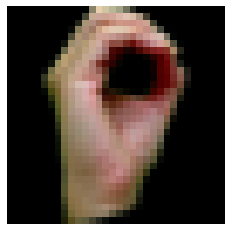

In [ ]:
display_image(img_misclass)

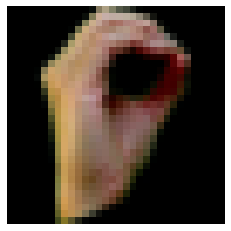

In [ ]:
display_image(img_correctclass)

# Self Supervised Learning


Lets suppose for a second that we wanted to add self supervised learning to these models.  Instead of the clean data set that we have at the moment, we have a huge dataset filled with ASL images that do not have labels. However, we can notice the following about the dataset:


*   Even without the ASL classification, it is easy to tell that two images belong to the same class
*   We can easily label some of the data.

We can use the idea of a self-training model in this case.  This involves three key steps:

* Train a classifier on a small set of labeled data
* Use the classifier to make pseudo labels for the unlabeled data
* Use both the original labeled data and the pseudo labeled data to retrain the model

We can repeat these steps as many times as we want until the probability threshold of the pseudo labeled data is high enough.  This would be much more efficient than random guessing.

One website used a good example.  When we train a model with the labeled data this can be considered our "teacher" model.  We then use the "teacher" model to generate labels.  Now we train or teach a "student" model using the teacher model.  We can then use the previous "student" model as the next "teacher" model to continue the process.  

In this case, suppose we had an enomorous data set of ASL images with no labels.  I would spend the time, to label a small amount of the data because if I were to do it all it would take potentially weeks or months (or maybe I'm just lazy). We would then:


1. Use the labeled data to train a classifier
2. Use the teacher model to generate labels for the our unlabeled data.  Perhaps selecting the most probable class as the one that we use for pseudo labeling.
3. Repeat the process until we have at least a 90% probability of one class in predicting the labels in step 2.

The two websites that helped me to understand this concept were [here](https://towardsdatascience.com/self-supervised-pre-training-self-training-which-one-to-use-8c796be3779e) and [here](https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38).

This task will help improve my models a lot.  It is very easy to have patterns in ASL.  For example, there is only so many ways you can sign an "a".  This allows for training to happen relatively quickly instead of spending time on labeling.   This can also help with labeling much more complex words in sign language if these models were to be expanded upon





# Conclusion

Overall I did not think the models would perform this well on only 15 epochs.  The reason for this I believe was the data.  All of the signs were shown with the hand in the center of the frame and they all had a black background. This made it easy for the model to focus on certain features.  To really test the models, it may be helpful to use data that is not so clean.  

One thing that was noted in adding regularization, is it greatly improved our models' performance.  A 94% accuracy vs 97% accuracy.  This I believe was due to helping the model with overfitting since we didn't have many training examples.


I think it would be really cool to use this as a backing for real time image recongnition.  Maybe using a webcam to have the computer interpret signs that are shown by the user.   The Kaggle dataset did not have a competition for this dataset but the instructions make it clear that it is possible to get close to 98% accuracy.  Which we nearly achieved.